In [1]:
import pyspark as ps
import pyspark.sql.functions as f
from pyspark import SQLContext
from pyspark.sql.types import IntegerType, DateType, TimestampType
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("seaborn-pastel")
import scipy.stats as stats
import numpy as np

In [2]:
spark = (ps.sql.SparkSession.builder 
        .master("local[4]") 
        .appName("sparkSQL exercise") 
        .getOrCreate()
        )
sc = spark.sparkContext

In [3]:
sc

<SparkContext master=local[4] appName=sparkSQL exercise>

In [4]:
sqlContext = SQLContext(sc)

In [5]:
df = sqlContext.read.csv("data/uk100.csv", header=True)

In [6]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- rank: string (nullable = true)
 |-- last_week_rank: string (nullable = true)
 |-- hmm: string (nullable = true)
 |-- title: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- label: string (nullable = true)
 |-- peak_rank: string (nullable = true)
 |-- weeks_on_chart: string (nullable = true)
 |-- week_of: string (nullable = true)



In [7]:
df.createOrReplaceTempView('test')

In [8]:
spark.sql('''SELECT *
            FROM test
            LIMIT 30
            ''').show()

+---+----+--------------+--------+--------------------+--------------------+--------------------+---------+--------------+----------------+
|_c0|rank|last_week_rank|     hmm|               title|              artist|               label|peak_rank|weeks_on_chart|         week_of|
+---+----+--------------+--------+--------------------+--------------------+--------------------+---------+--------------+----------------+
|  0|   1|            11|        |               RIVER|      ELLIE GOULDING|             POLYDOR|        1|             5|December 27 2019|
|  1|   2|             8|        |ALL I WANT FOR CH...|        MARIAH CAREY|            COLUMBIA|        2|            99|December 27 2019|
|  2|   3|             5|        |      LAST CHRISTMAS|                WHAM|                 RCA|        2|            64|December 27 2019|
|  3|   4|            14|        |FAIRYTALE OF NEW ...|POGUES FT KIRSTY ...|         WARNER BROS|        2|            99|December 27 2019|
|  4|   5|          

## Drop unneeded columns and cast the rest to the correct types.

In [9]:
df = df.drop('_c0')
df = df.drop('hmm')

for col in df.columns:
    df = df.withColumn(col, f.lower(f.col(col)))

df = df.withColumn("rank", df["rank"].cast(IntegerType()))
df = df.withColumn("peak_rank", df["peak_rank"].cast(IntegerType()))
df = df.withColumn("weeks_on_chart", df["weeks_on_chart"].cast(IntegerType()))

def to_date(x):
    return datetime.strptime(x, '%B %d %Y')
change_to_datetype = f.udf(lambda y: to_date(y), DateType())

df = df.withColumn("week_of", change_to_datetype('week_of'))

In [10]:
df.printSchema()

root
 |-- rank: integer (nullable = true)
 |-- last_week_rank: string (nullable = true)
 |-- title: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- label: string (nullable = true)
 |-- peak_rank: integer (nullable = true)
 |-- weeks_on_chart: integer (nullable = true)
 |-- week_of: date (nullable = true)



In [11]:
df.createOrReplaceTempView('test')

## Total Count

In [12]:
spark.sql('''
        SELECT COUNT(*)
        FROM test
        ''').show()

+--------+
|count(1)|
+--------+
|   26000|
+--------+



In [13]:
spark.sql('''
        SELECT *
        FROM test
        ''').show()

+----+--------------+--------------------+--------------------+--------------------+---------+--------------+----------+
|rank|last_week_rank|               title|              artist|               label|peak_rank|weeks_on_chart|   week_of|
+----+--------------+--------------------+--------------------+--------------------+---------+--------------+----------+
|   1|            11|               river|      ellie goulding|             polydor|        1|             5|2019-12-27|
|   2|             8|all i want for ch...|        mariah carey|            columbia|        2|            99|2019-12-27|
|   3|             5|      last christmas|                wham|                 rca|        2|            64|2019-12-27|
|   4|            14|fairytale of new ...|pogues ft kirsty ...|         warner bros|        2|            99|2019-12-27|
|   5|             2|              own it|stormzy/ed sheera...|      atlantic/merky|        2|             5|2019-12-27|
|   6|            16|merry chris

## Number of distinct titles that have reached rank 1

In [14]:
spark.sql('''
        SELECT COUNT(DISTINCT title)
        FROM test
        WHERE rank == 1''').show()

+---------------------+
|count(DISTINCT title)|
+---------------------+
|                   77|
+---------------------+



## Number of unique songs

In [15]:
num_unique_songs = spark.sql('''
        SELECT artist, title
        FROM test
        GROUP BY artist, title''')

In [16]:
num_unique_songs.count()

2605

## How many weeks did these songs stay at rank 1

In [17]:
spark.sql('''
            SELECT DISTINCT artist, title, COUNT(*) as num_weeks, MIN(week_of)
            FROM test
            WHERE rank == 1
            GROUP BY 1, 2
            ORDER BY 3 DESC
            ''').show()

+--------------------+--------------------+---------+------------+
|              artist|               title|num_weeks|min(week_of)|
+--------------------+--------------------+---------+------------+
|drake ft wizkid &...|           one dance|       15|  2016-04-15|
|          ed sheeran|        shape of you|       14|  2017-01-13|
|           tones & i|        dance monkey|       11|  2019-10-04|
|luis fonsi/daddy ...|   despacito (remix)|       11|  2017-05-12|
|               drake|          god's plan|        9|  2018-01-26|
|        clean bandit|            rockabye|        9|  2016-11-11|
|ed sheeran & just...|        i don't care|        8|  2019-05-17|
|calvin harris & d...|            one kiss|        8|  2018-04-20|
|       lewis capaldi|   someone you loved|        7|  2019-03-01|
|calvin harris & s...|            promises|        6|  2018-09-07|
|          ed sheeran|             perfect|        6|  2017-12-08|
|shawn mendes/cami...|            senorita|        6|  2019-07

## Total number of appearances on the top 100 tht peaked at rank 1, in order

In [18]:
spark.sql('''
            SELECT DISTINCT artist, title, COUNT(*) as num_weeks, MIN(week_of)
            FROM test
            WHERE peak_rank == 1
            GROUP BY 1,2
            ORDER BY 3 DESC
            ''').show()

+--------------------+--------------------+---------+------------+
|              artist|               title|num_weeks|min(week_of)|
+--------------------+--------------------+---------+------------+
|          ed sheeran|        shape of you|       97|  2017-01-13|
|          ed sheeran|   thinking out loud|       90|  2015-01-11|
|          ed sheeran|             perfect|       81|  2017-12-08|
|         george ezra|             shotgun|       74|  2018-06-29|
|mark ronson ft br...|         uptown funk|       72|  2015-01-11|
|luis fonsi/daddy ...|   despacito (remix)|       71|  2017-05-12|
|       justin bieber|               sorry|       65|  2015-11-20|
|drake ft wizkid &...|           one dance|       64|  2016-04-15|
|       justin bieber|    what do you mean|       62|  2015-09-04|
|       justin bieber|       love yourself|       62|  2015-12-04|
|            dua lipa|           new rules|       61|  2017-08-18|
|       years & years|                king|       59|  2015-03

## Average lifespan (songs that hit rank 1)

In [19]:
spark.sql('''
            SELECT AVG(num_weeks)
            FROM (SELECT DISTINCT title, COUNT(*) as num_weeks
                    FROM test
                    WHERE peak_rank == 1
                    GROUP BY 1
                    ORDER BY 2 DESC)
            ''').show()

+------------------+
|    avg(num_weeks)|
+------------------+
|26.708661417322833|
+------------------+



## Average lifespan (overall)

In [20]:
spark.sql('''
            SELECT AVG(num_weeks)
            FROM (SELECT title, COUNT(*) as num_weeks
                    FROM test
                    
                    GROUP BY 1, artist
                    ORDER BY 2 DESC)
            ''').show()

+-----------------+
|   avg(num_weeks)|
+-----------------+
|9.980806142034549|
+-----------------+



## Histogram of lifespans

In [79]:
lifespan_count = spark.sql('''
            SELECT artist, title, MAX(weeks_on_chart) as num_weeks
            FROM test
            GROUP BY artist, title''')

In [80]:
lifespan_count = lifespan_count.rdd.map(lambda row: row.num_weeks).collect()

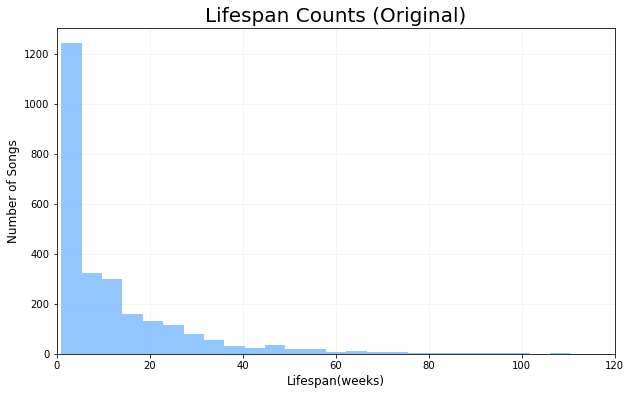

In [82]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(lifespan_count, bins=50)
ax.set_xlim(0, 120)

ax.set_title("Lifespan Counts (Original)", fontsize=20)
ax.set_ylabel("Number of Songs", fontsize=12)
ax.set_xlabel("Lifespan(weeks)", fontsize=12)
ax.grid(alpha=0.15)
plt.savefig("img/Lifespan_counts_original.png")

## Average rank for the song "Shape of You" by Ed Sheeran

In [21]:
spark.sql('''
            SELECT ROUND(AVG(rank),2), MAX(weeks_on_chart)
            FROM test
            WHERE title = "shape of you"
            ''').show()

+-----------------------------------+-------------------+
|round(avg(CAST(rank AS BIGINT)), 2)|max(weeks_on_chart)|
+-----------------------------------+-------------------+
|                              42.52|                 97|
+-----------------------------------+-------------------+



## Average rank and number of weeks on chart per song

In [22]:
spark.sql('''
            SELECT artist, title, AVG(rank), COUNT(*)
            FROM test
            GROUP BY artist, title''').show()

+--------------------+--------------------+------------------+--------+
|              artist|               title|         avg(rank)|count(1)|
+--------------------+--------------------+------------------+--------+
|          elton john| step into christmas|  38.8421052631579|      19|
|clean bandit ft e...|                mama|              98.0|       1|
|            m o/chip|           wondering|              91.0|       1|
|               drake|             nonstop| 40.84615384615385|      13|
|florence & the ma...|             big god|              97.0|       1|
|raye/mabel/steffl...|           cigarette|              55.5|      16|
|   jax jones ft raye|   you don't know me| 36.24242424242424|      33|
|ryan gosling & em...|       city of stars|             68.25|       4|
|kygo ft ella hend...|        here for you|              52.0|      10|
|sigma ft paloma f...|            changing| 65.22222222222223|      18|
|        adam lambert|          ghost town|              76.5|  

## Create new db of new songs only

## Left semi join to remove non-new songs from original db

In [23]:
new_songs = spark.sql('''
            SELECT artist, title
            FROM test
            WHERE last_week_rank like "%new%"''')

In [24]:
new_songs_2015_2019 = df.join(new_songs, ['title', 'artist'],how='leftsemi')

In [25]:
new_songs_2015_2019.count()

22822

In [26]:
new_songs_2015_2019.createOrReplaceTempView('count_test')

In [27]:
spark.sql('''
            SELECT artist, title
            FROM count_test
            GROUP BY artist, title''').count()

2339

In [28]:
peak_75 = spark.sql('''
            SELECT artist, title, MIN(peak_rank) as real_peak
            FROM test
            
            GROUP BY artist, title
            HAVING real_peak <= 75
            ''')

In [29]:
peak_75.count()

2048

In [30]:
songs_2015_2019 = new_songs_2015_2019.join(peak_75, ['title', 'artist'],how='leftsemi')

In [31]:
songs_2015_2019.createOrReplaceTempView('test2')

In [32]:
spark.sql('''
            SELECT *
            FROM test2''').show()

+--------------------+--------------------+----+--------------+--------------------+---------+--------------+----------+
|               title|              artist|rank|last_week_rank|               label|peak_rank|weeks_on_chart|   week_of|
+--------------------+--------------------+----+--------------+--------------------+---------+--------------+----------+
|               river|      ellie goulding|   1|            11|             polydor|        1|             5|2019-12-27|
|              own it|stormzy/ed sheera...|   5|             2|      atlantic/merky|        2|             5|2019-12-27|
|happy christmas (...|         john legend|   9|            34|            columbia|        9|             3|2019-12-27|
|       before you go|       lewis capaldi|  12|             3|                 emi|        2|             6|2019-12-27|
|     don't start now|            dua lipa|  14|             4|      warner records|        2|             8|2019-12-27|
|             roxanne|      ariz

In [33]:
spark.sql('''
            SELECT COUNT(*)
            FROM test2''').show()

+--------+
|count(1)|
+--------+
|   21880|
+--------+



In [34]:
spark.sql('''
            SELECT artist, title
            FROM test2
            GROUP BY artist, title''').show()

+--------------------+--------------------+
|              artist|               title|
+--------------------+--------------------+
|               drake|             nonstop|
|raye/mabel/steffl...|           cigarette|
|   jax jones ft raye|   you don't know me|
|ryan gosling & em...|       city of stars|
|kygo ft ella hend...|        here for you|
|        adam lambert|          ghost town|
|               ciara|               i bet|
|charli xcx ft rit...|            doing it|
|       bars & melody|        keep smiling|
|clean bandit ft d...|                solo|
|               drake| diplomatic immunity|
|        lil uzi vert|       xo tour llif3|
|teddy mac the son...|you make me feel ...|
|          little mix|                hair|
|           aronchupa|    i'm an albatraoz|
|dj fresh ft ella ...|             gravity|
|               drake|         behind barz|
| lil nas x & cardi b|               rodeo|
|asap rocky ft skepta|praise the lord (...|
|kygo ft justin jesso|          

In [35]:
spark.sql('''
            SELECT COUNT(*)
            FROM (SELECT artist, title
                FROM test2
                GROUP BY artist, title)''').show()

+--------+
|count(1)|
+--------+
|    1785|
+--------+



In [36]:
songs_2015_2019.printSchema()

root
 |-- title: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- rank: integer (nullable = true)
 |-- last_week_rank: string (nullable = true)
 |-- label: string (nullable = true)
 |-- peak_rank: integer (nullable = true)
 |-- weeks_on_chart: integer (nullable = true)
 |-- week_of: date (nullable = true)



## number of appearances per song and avg rank

In [37]:
spark.sql('''
            SELECT title, artist, count(*), ROUND(AVG(rank),2), MIN(week_of) as week_entered
            FROM test2
            GROUP BY title, artist
            ORDER BY 3 DESC''').show()

+--------------------+--------------------+--------+-----------------------------------+------------+
|               title|              artist|count(1)|round(avg(CAST(rank AS BIGINT)), 2)|week_entered|
+--------------------+--------------------+--------+-----------------------------------+------------+
|             perfect|          ed sheeran|     110|                              48.09|  2017-03-10|
|        shape of you|          ed sheeran|      97|                              42.52|  2017-01-13|
|             shotgun|         george ezra|      87|                              35.99|  2018-03-30|
|             lean on|major lazer ft mo...|      79|                              45.92|  2015-03-08|
|          this is me|settle/greatest s...|      75|                              40.84|  2018-01-05|
|     shut up & dance|       walk the moon|      72|                              54.63|  2015-06-07|
|can't stop the fe...|   justin timberlake|      71|                              

In [38]:
spark.sql('''
            SELECT AVG(count)
            FROM (SELECT title, artist, COUNT(*) as count
                FROM test2
                GROUP BY 1,2
                HAVING count >4
                ORDER BY 3)
            ''').show()

+------------------+
|        avg(count)|
+------------------+
|17.761658031088082|
+------------------+



## Number of appearances by label

In [39]:
spark.sql('''
            SELECT label, COUNT(*)
            FROM test2
            GROUP BY 1
            ORDER BY 2 DESC
            ''').show()

+--------------------+--------+
|               label|count(1)|
+--------------------+--------+
|            atlantic|    1924|
|          interscope|    1349|
|            columbia|    1269|
|             polydor|    1118|
|                 rca|     926|
|    republic records|     758|
|          syco music|     710|
|                 emi|     705|
|              virgin|     671|
|              asylum|     645|
|cash money/republ...|     619|
|          parlophone|     602|
|              island|     558|
|         warner bros|     540|
|             capitol|     460|
|             def jam|     451|
|   ministry of sound|     414|
|            positiva|     360|
|                epic|     345|
|          relentless|     339|
+--------------------+--------+
only showing top 20 rows



In [40]:
spark.sql('''
            SELECT COUNT(DISTINCT label)
            FROM test2
            ''').show()

+---------------------+
|count(DISTINCT label)|
+---------------------+
|                  315|
+---------------------+



## Average rank of each label

In [41]:
spark.sql('''
            SELECT label, COUNT(DISTINCT title) AS num_songs, ROUND(AVG(rank),2) AS avg_rank
            FROM test2
            GROUP BY 1
            ORDER BY 2 DESC
            ''').show()

+--------------------+---------+--------+
|               label|num_songs|avg_rank|
+--------------------+---------+--------+
|          interscope|      123|   47.68|
|            atlantic|      103|   45.62|
|            columbia|       91|   45.94|
|             polydor|       90|   48.54|
|                 rca|       76|   51.01|
|              virgin|       75|   50.71|
|cash money/republ...|       64|   48.47|
|              island|       56|   50.87|
|          syco music|       53|   44.35|
|                 emi|       52|   45.19|
|    republic records|       46|   42.41|
|             def jam|       44|   51.08|
|          parlophone|       43|   46.49|
|         warner bros|       37|   46.71|
|             capitol|       33|   44.19|
|              asylum|       32|   44.52|
|   ministry of sound|       30|    44.4|
| republic records/xo|       23|   45.06|
|                epic|       23|   52.12|
|          relentless|       18|   52.24|
+--------------------+---------+--

In [42]:
spark.sql('''
            SELECT label, COUNT(DISTINCT title) AS num_songs, ROUND(AVG(rank),2) AS avg_rank
            FROM test2
            GROUP BY 1
            HAVING num_songs >15
            ORDER BY 3
            ''').show(50, False)

+---------------------------+---------+--------+
|label                      |num_songs|avg_rank|
+---------------------------+---------+--------+
|republic records           |46       |42.41   |
|positiva                   |18       |43.13   |
|capitol                    |33       |44.19   |
|syco music                 |53       |44.35   |
|ministry of sound          |30       |44.4    |
|asylum                     |32       |44.52   |
|republic records/xo        |23       |45.06   |
|emi                        |52       |45.19   |
|atlantic                   |103      |45.62   |
|columbia                   |91       |45.94   |
|parlophone                 |43       |46.49   |
|warner bros                |37       |46.71   |
|interscope                 |123      |47.68   |
|cash money/republic records|64       |48.47   |
|polydor                    |90       |48.54   |
|virgin                     |75       |50.71   |
|island                     |56       |50.87   |
|rca                

## Average rank per label (without collabs)

In [43]:
spark.sql('''
            SELECT label, COUNT(DISTINCT title), ROUND(AVG(rank),2) AS avg_rank
            FROM test2
            WHERE label NOT IN (SELECT label
                                FROM test2
                                WHERE label like "%/%"
                                GROUP BY label)
            GROUP BY 1
            ORDER BY 2 DESC
            ''').show(20, False)

+-----------------+---------------------+--------+
|label            |count(DISTINCT title)|avg_rank|
+-----------------+---------------------+--------+
|interscope       |123                  |47.68   |
|atlantic         |103                  |45.62   |
|columbia         |91                   |45.94   |
|polydor          |90                   |48.54   |
|rca              |76                   |51.01   |
|virgin           |75                   |50.71   |
|island           |56                   |50.87   |
|syco music       |53                   |44.35   |
|emi              |52                   |45.19   |
|republic records |46                   |42.41   |
|def jam          |44                   |51.08   |
|parlophone       |43                   |46.49   |
|warner bros      |37                   |46.71   |
|capitol          |33                   |44.19   |
|asylum           |32                   |44.52   |
|ministry of sound|30                   |44.4    |
|epic             |23          

## Most appearances by artist

In [44]:
spark.sql('''
            SELECT DISTINCT artist, COUNT(*), ROUND(AVG(rank),2) AS avg_rank
            FROM test2
            GROUP BY 1
            ORDER BY 2 DESC''').show()

+--------------+--------+--------+
|        artist|count(1)|avg_rank|
+--------------+--------+--------+
|    ed sheeran|     440|   45.51|
|         drake|     328|   46.52|
| justin bieber|     258|   45.78|
| ariana grande|     254|   39.24|
|    little mix|     241|   45.37|
|  shawn mendes|     212|   42.69|
|   jess glynne|     203|   43.39|
|   george ezra|     194|   45.12|
|        weeknd|     183|   44.96|
|      dua lipa|     172|   41.03|
| lewis capaldi|     158|   29.18|
| years & years|     156|    45.3|
|  zara larsson|     142|   43.61|
|       stormzy|     141|   48.94|
|ellie goulding|     139|   44.53|
|   post malone|     136|   45.18|
|  taylor swift|     131|   50.73|
|    anne-marie|     122|   44.04|
|      coldplay|     120|   47.46|
|         adele|     118|    48.0|
+--------------+--------+--------+
only showing top 20 rows



## More Ed Sheeran

In [45]:
spark.sql('''
            SELECT title, COUNT(*), MIN(rank) as peak, MIN(week_of)
            FROM test2
            WHERE artist = "ed sheeran"
            GROUP BY 1
            ORDER BY 2 DESC
            ''').show(30, False)

+------------------------------+--------+----+------------+
|title                         |count(1)|peak|min(week_of)|
+------------------------------+--------+----+------------+
|perfect                       |110     |1   |2017-03-10  |
|shape of you                  |97      |1   |2017-01-13  |
|castle on the hill            |53      |2   |2017-01-13  |
|galway girl                   |31      |2   |2017-03-10  |
|supermarket flowers           |21      |8   |2017-03-10  |
|happier                       |18      |6   |2017-03-10  |
|what do i know                |17      |9   |2017-03-10  |
|new man                       |14      |5   |2017-03-10  |
|dive                          |13      |8   |2017-03-10  |
|barcelona                     |13      |12  |2017-03-10  |
|how would you feel (paean)    |12      |2   |2017-02-24  |
|nancy mulligan                |10      |13  |2017-03-10  |
|bibia be ye ye                |8       |18  |2017-03-10  |
|hearts don't break around here|8       

In [46]:
spark.sql('''
            SELECT title, COUNT(*), MIN(rank) as peak, MIN(week_of)
            FROM test2
            WHERE artist = "ed sheeran"
            GROUP BY 1
            HAVING peak < 6
            ORDER BY 2 DESC
            ''').show(20, False)

+--------------------------+--------+----+------------+
|title                     |count(1)|peak|min(week_of)|
+--------------------------+--------+----+------------+
|perfect                   |110     |1   |2017-03-10  |
|shape of you              |97      |1   |2017-01-13  |
|castle on the hill        |53      |2   |2017-01-13  |
|galway girl               |31      |2   |2017-03-10  |
|new man                   |14      |5   |2017-03-10  |
|how would you feel (paean)|12      |2   |2017-02-24  |
+--------------------------+--------+----+------------+



In [47]:
spark.sql('''
            SELECT COUNT(DISTINCT title)
            FROM test2
            WHERE artist = "ed sheeran"
            
            ''').show()

+---------------------+
|count(DISTINCT title)|
+---------------------+
|                   17|
+---------------------+



In [48]:
df.printSchema() #table = test
songs_2015_2019.printSchema() # table = test2

root
 |-- rank: integer (nullable = true)
 |-- last_week_rank: string (nullable = true)
 |-- title: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- label: string (nullable = true)
 |-- peak_rank: integer (nullable = true)
 |-- weeks_on_chart: integer (nullable = true)
 |-- week_of: date (nullable = true)

root
 |-- title: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- rank: integer (nullable = true)
 |-- last_week_rank: string (nullable = true)
 |-- label: string (nullable = true)
 |-- peak_rank: integer (nullable = true)
 |-- weeks_on_chart: integer (nullable = true)
 |-- week_of: date (nullable = true)



## Life of songs (ordered by first entrance date) with avg rank over life

In [49]:
spark.sql('''
            SELECT artist, title, COUNT(*) AS num_weeks, ROUND(AVG(rank),2) AS avg_rank, MIN(week_of) AS entrance_date
            FROM test2
            GROUP BY 1,2
            ORDER BY 5''').show()

+--------------------+--------------------+---------+--------+-------------+
|              artist|               title|num_weeks|avg_rank|entrance_date|
+--------------------+--------------------+---------+--------+-------------+
|        fall out boy|        irresistible|        2|    75.5|   2015-01-11|
|                 omi|         cheerleader|       16|   60.81|   2015-01-11|
|kygo ft conrad se...|           firestone|       55|   46.56|   2015-01-11|
|tchami ft kaleem ...|           promesses|        9|   43.33|   2015-01-11|
|fuse odg ft killb...|    thinking about u|        3|   80.67|   2015-01-11|
|              tulisa|  living without you|        1|    44.0|   2015-01-11|
|           james bay|               scars|        9|   76.89|   2015-01-11|
|              avicii|          the nights|       33|   35.27|   2015-01-18|
|kid ink ft chris ...|               hotel|        5|    53.4|   2015-01-18|
|    big sean ft e-40|i don't f**k with...|       13|   81.54|   2015-01-18|

## starting rank

In [50]:
spark.sql('''
            SELECT artist, title, rank, week_of
            FROM test2
            WHERE weeks_on_chart = 1
            ORDER BY 4''').show()

+--------------------+--------------------+----+----------+
|              artist|               title|rank|   week_of|
+--------------------+--------------------+----+----------+
|fuse odg ft killb...|    thinking about u|  79|2015-01-11|
|              tulisa|  living without you|  44|2015-01-11|
|kygo ft conrad se...|           firestone|  97|2015-01-11|
|           james bay|               scars|  63|2015-01-11|
|                 omi|         cheerleader|  96|2015-01-11|
|tchami ft kaleem ...|           promesses|   7|2015-01-11|
|        fall out boy|        irresistible|  70|2015-01-11|
|              avicii|          the nights|  16|2015-01-18|
|        fall out boy|american beauty/a...|  89|2015-01-18|
|noel gallagher's ...|ballad of the mig...|  75|2015-01-18|
|kid ink ft chris ...|               hotel|  43|2015-01-18|
|        fall out boy|         uma thurman|  71|2015-01-18|
|    big sean ft e-40|i don't f**k with...|  97|2015-01-18|
|          rae morris|   under the shado

## Final DF

In [51]:
final_df = spark.sql('''
            SELECT artist, title, COUNT(*) AS num_weeks, ROUND(AVG(rank),2) AS avg_rank, MIN(week_of) AS entrance_date
            FROM test2
            GROUP BY 1,2
            ORDER BY 5''')

In [52]:
final_df.createOrReplaceTempView('test3')

In [53]:
final_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- title: string (nullable = true)
 |-- num_weeks: long (nullable = false)
 |-- avg_rank: double (nullable = true)
 |-- entrance_date: date (nullable = true)



In [54]:
spark.sql('''
            SELECT COUNT(*)
            FROM test3''').show()

+--------+
|count(1)|
+--------+
|    1785|
+--------+



In [55]:
survival = spark.sql('''
            SELECT *
            FROM test3
            ''')

In [56]:
lifespan = survival.rdd.map(lambda row: row.num_weeks).collect()

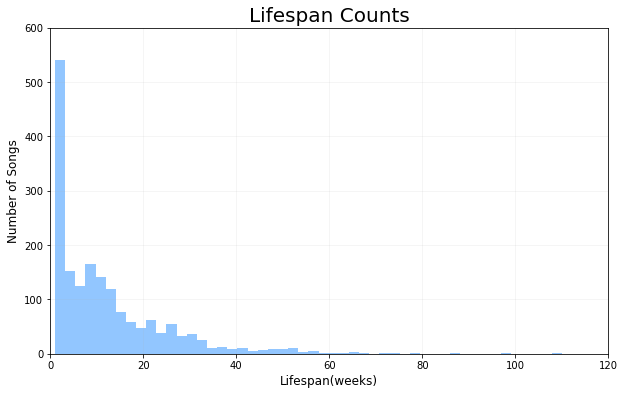

In [57]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(lifespan, bins=50)
ax.set_xlim(0, 120)
ax.set_ylim(0, 600)
ax.set_title("Lifespan Counts", fontsize=20)
ax.set_ylabel("Number of Songs", fontsize=12)
ax.set_xlabel("Lifespan(weeks)", fontsize=12)
ax.grid(alpha=0.15)
plt.savefig("img/Lifespan_counts.png")

In [58]:
spark.sql('''
            SELECT *
            FROM test3
            ORDER BY num_weeks DESC''').show()

+--------------------+--------------------+---------+--------+-------------+
|              artist|               title|num_weeks|avg_rank|entrance_date|
+--------------------+--------------------+---------+--------+-------------+
|          ed sheeran|             perfect|      110|   48.09|   2017-03-10|
|          ed sheeran|        shape of you|       97|   42.52|   2017-01-13|
|         george ezra|             shotgun|       87|   35.99|   2018-03-30|
|major lazer ft mo...|             lean on|       79|   45.92|   2015-03-08|
|settle/greatest s...|          this is me|       75|   40.84|   2018-01-05|
|       walk the moon|     shut up & dance|       72|   54.63|   2015-06-07|
|   justin timberlake|can't stop the fe...|       71|   46.94|   2016-05-13|
|       justin bieber|               sorry|       68|   41.43|   2015-10-30|
|        shawn mendes|            stitches|       67|   47.63|   2015-09-25|
|            dua lipa|           new rules|       66|   43.92|   2017-07-14|

In [59]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

In [60]:
num_per_month = spark.sql('''
            SELECT MONTH(entrance_date) as month, COUNT(*) as num_songs
            FROM test3
            WHERE entrance_date < "2019-01-01"
            GROUP BY MONTH(entrance_date)
            ORDER BY 1
            ''')

In [61]:
num_per_month = num_per_month.rdd.map(lambda row: row.num_songs).collect()

In [62]:
num_per_month

[91, 104, 162, 125, 134, 109, 100, 101, 112, 115, 129, 80]

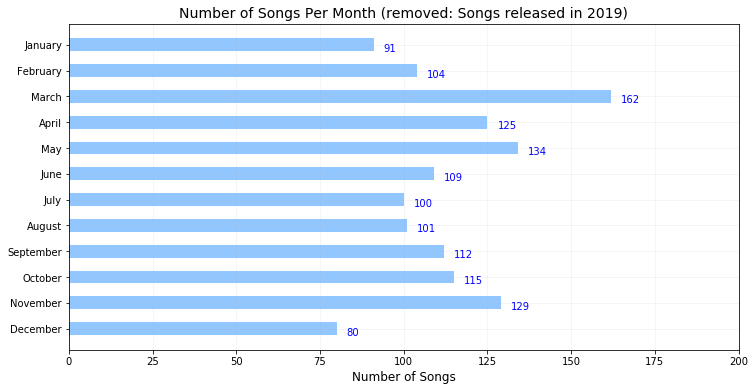

In [63]:
fig, ax = plt.subplots(figsize=(12,6))

ax.barh(months, num_per_month, height=0.5)
ax.invert_yaxis()
for i, v in enumerate(num_per_month):
    ax.text(v + 3, i + .25, str(v), color='blue')
ax.set_xlim(0,200)
ax.set_title('Number of Songs Per Month (removed: Songs released in 2019)', fontsize=14)
ax.set_xlabel("Number of Songs", fontsize=12)
ax.grid(alpha=0.15)
plt.savefig("img/num_songs_month.png")

In [64]:
spark.sql('''
            SELECT MONTH(entrance_date), ROUND(AVG(num_weeks),2)
            FROM test3
            WHERE entrance_date < "2019-01-01"
            GROUP BY MONTH(entrance_date)
            ORDER BY 1''').show()

+--------------------+------------------------+
|month(entrance_date)|round(avg(num_weeks), 2)|
+--------------------+------------------------+
|                   1|                   17.88|
|                   2|                   13.49|
|                   3|                   13.53|
|                   4|                   12.13|
|                   5|                   12.81|
|                   6|                   13.82|
|                   7|                   13.08|
|                   8|                   15.47|
|                   9|                    13.9|
|                  10|                    13.7|
|                  11|                   11.95|
|                  12|                    9.83|
+--------------------+------------------------+



In [65]:
avg_lifespan_overall = spark.sql('''
            SELECT ROUND(AVG(num_weeks),2) AS avg_lifespan_overall
            FROM test3
            WHERE entrance_date < "2019-01-01"''').show()

+--------------------+
|avg_lifespan_overall|
+--------------------+
|               13.43|
+--------------------+



In [66]:
avg_lifespan_per_month = spark.sql('''
            SELECT MONTH(entrance_date) AS month, ROUND(AVG(num_weeks),2) AS avg_lifespan
            FROM test3
            WHERE entrance_date < "2019-01-01"
            GROUP BY MONTH(entrance_date)
            ORDER BY 1''')

In [67]:
avg_lifespan = avg_lifespan_per_month.rdd.map(lambda row: row.avg_lifespan).collect()

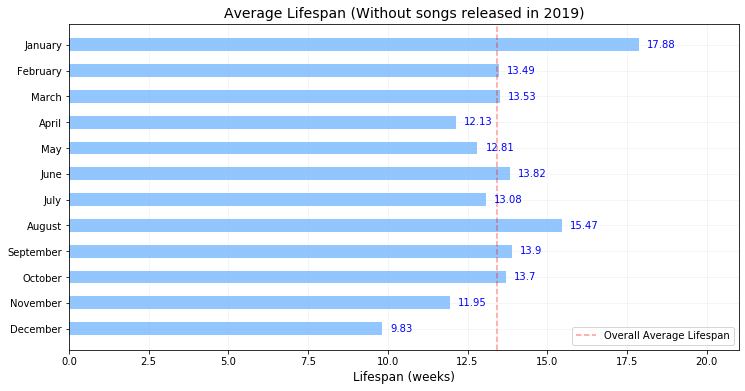

In [68]:
fig, ax = plt.subplots(figsize=(12,6))

ax.barh(months, avg_lifespan, height=0.5)
ax.invert_yaxis()
for i, v in enumerate(avg_lifespan):
    ax.text(v + 0.25, i + .1, str(v), color='blue')
ax.axvline(13.43, color='r', linestyle="--", alpha=0.4, label="Overall Average Lifespan")
ax.set_xlim(0,21)
ax.set_title('Average Lifespan (Without songs released in 2019)', fontsize=14)
ax.set_xlabel("Lifespan (weeks)", fontsize=12)
ax.legend()
ax.grid(alpha=0.15)
plt.savefig("img/avg_lifespan_month.png")

In [69]:
def samp(month):
    sample = spark.sql('''
                SELECT num_weeks
                FROM test3
                WHERE MONTH(entrance_date)={}
                    AND entrance_date < "2019-01-01"'''.format(month))
    return sample.rdd.map(lambda row: row.num_weeks).collect()

def samp_exclude_month(month):
    sample = spark.sql('''
                SELECT num_weeks
                FROM test3
                WHERE entrance_date < "2019-01-01"
                    AND MONTH(entrance_date) <> {}'''.format(month))
    return sample.rdd.map(lambda row: row.num_weeks).collect()

In [70]:
jan = samp(1)
not_jan = samp_exclude_month(1)
feb = samp(2)
not_feb = samp_exclude_month(2)
mar = samp(3)
not_mar = samp_exclude_month(3)
apr = samp(4)
not_apr = samp_exclude_month(4)
may = samp(5)
not_may = samp_exclude_month(5)
jun = samp(6)
not_jun = samp_exclude_month(6)
jul = samp(7)
not_jul = samp_exclude_month(7)
aug = samp(8)
not_aug = samp_exclude_month(8)
sep = samp(9)
not_sep = samp_exclude_month(9)
octo = samp(10)
not_octo = samp_exclude_month(10)
nov = samp(11)
not_nov = samp_exclude_month(11)
dec = samp(12)
not_dec = samp_exclude_month(12)

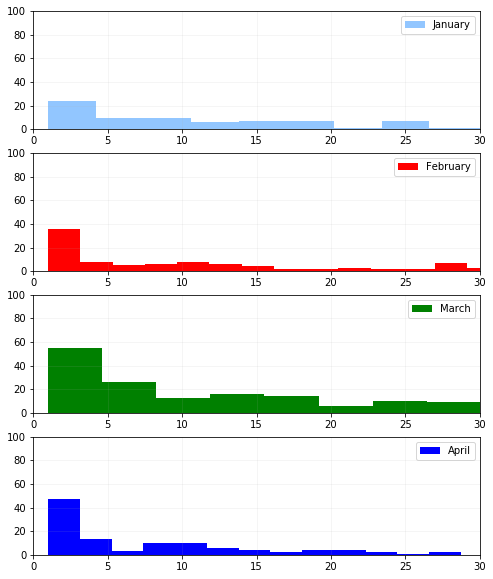

In [71]:
fig, axes= plt.subplots(4, figsize=(8,10))

axes[0].hist(jan, bins=30, label="January")
axes[1].hist(feb, bins=30, color="r", label="February")
axes[2].hist(mar, bins=30, color="g", label="March")
axes[3].hist(apr, bins=30, color="b", label="April")
for i in range(4):
    axes[i].set_ylim(0,100)
    axes[i].set_xlim(0, 30)
    axes[i].grid(alpha=0.15)
    axes[i].legend()

In [72]:
def bootstrap(x, resamples=1000):
    bootstrap_samples=[]
    for i in range(resamples):
        bootstrap = np.random.choice(x, size=30, replace=True)
        bootstrap_samples.append(np.mean(bootstrap))
    return bootstrap_samples
    


In [73]:
jan = bootstrap(jan)
feb = bootstrap(feb)
mar = bootstrap(mar)
apr = bootstrap(apr)
may = bootstrap(may)
jun = bootstrap(jun)
jul = bootstrap(jul)
aug = bootstrap(aug)
sep = bootstrap(sep)
octo = bootstrap(octo)
nov = bootstrap(nov)
dec = bootstrap(dec)

not_jan = bootstrap(not_jan)
not_feb = bootstrap(not_feb)
not_mar = bootstrap(not_mar)
not_apr = bootstrap(not_apr)
not_may = bootstrap(not_may)
not_jun = bootstrap(not_jun)
not_jul = bootstrap(not_jul)
not_aug = bootstrap(not_aug)
not_sep = bootstrap(not_sep)
not_octo = bootstrap(not_octo)
not_nov = bootstrap(not_nov)
not_dec = bootstrap(not_dec)


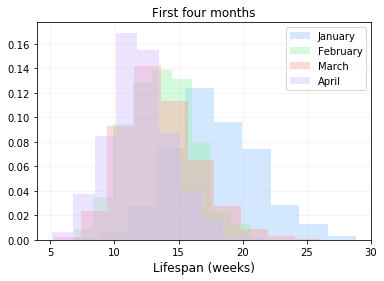

In [74]:
fig, ax = plt.subplots()
ax.hist(jan, alpha=.4, density=True, label="January")
ax.hist(feb, alpha=.4, density=True, label="February")
ax.hist(mar, alpha=.4, density=True, label="March")
ax.hist(apr, alpha=.4, density=True, label="April")
ax.set_title('First four months')
ax.set_xlabel("Lifespan (weeks)", fontsize=12)
ax.legend()
ax.grid(alpha=0.15)
plt.savefig("img/first_four_months.png")

In [75]:


_, p1 = stats.ttest_ind(jan,not_jan)
_, p2 = stats.ttest_ind(feb,not_feb)
_, p3 = stats.ttest_ind(mar,not_mar)
_, p4 = stats.ttest_ind(apr,not_apr)
_, p5 = stats.ttest_ind(may,not_may)
_, p6 = stats.ttest_ind(jun,not_jun)
_, p7 = stats.ttest_ind(jul,not_jul)
_, p8 = stats.ttest_ind(aug,not_aug)
_, p9 = stats.ttest_ind(sep,not_sep)
_, p10 = stats.ttest_ind(octo,not_octo)
_, p11 = stats.ttest_ind(nov,not_nov)
_, p12 = stats.ttest_ind(dec,not_dec)

alpha = 0.05/12
print("corrected alpha = {}".format(alpha))
print("Jan vs rest = "+ str(p1))
print("Feb vs rest = "+ str(p2))
print("Mar vs rest = "+ str(p3))
print("Apr vs rest = "+ str(p4))
print("May vs rest = "+str(p5))
print("Jun vs rest = "+str(p6))
print("Jul vs rest = "+str(p7))
print("Aug vs rest = "+str(p8))
print("Sep vs rest = "+str(p9))
print("Oct vs rest = "+str(p10))
print("Nov vs rest = "+str(p11))
print("Dec vs rest = "+str(p12))

corrected alpha = 0.004166666666666667
Jan vs rest = 1.1238765120724023e-218
Feb vs rest = 0.02221184602615466
Mar vs rest = 0.021887849527000784
Apr vs rest = 2.9852612307170152e-40
May vs rest = 4.2279649417257105e-10
Jun vs rest = 3.886858550605457e-06
Jul vs rest = 0.0003782468859613491
Aug vs rest = 8.702493589426346e-88
Sep vs rest = 9.427033867124077e-10
Oct vs rest = 0.0642181950040024
Nov vs rest = 1.8142931441988762e-47
Dec vs rest = 1.3248289999081888e-261


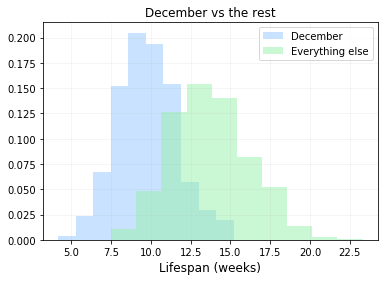

In [76]:
fig, ax = plt.subplots()
ax.hist(dec, alpha=0.5, label="December", density=True)
ax.hist(not_dec, alpha=0.5, label="Everything else", density=True)
ax.set_title('December vs the rest')
ax.set_xlabel("Lifespan (weeks)", fontsize=12)
ax.legend()
ax.grid(alpha=0.15)
plt.savefig("img/dec_vs_rest.png")

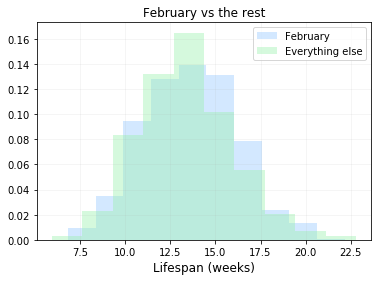

In [77]:
fig, ax = plt.subplots()
ax.hist(feb, alpha=0.4, label="February", density=True)
ax.hist(not_feb, alpha=0.4, label="Everything else", density=True)
ax.set_title('February vs the rest')
ax.set_xlabel("Lifespan (weeks)", fontsize=12)
ax.legend()
ax.grid(alpha=0.15)
plt.savefig("img/feb_vs_rest.png")